In [ ]:
from sklearn import svm, metrics
import glob, os.path, re, json
# 텍스트를 읽어 들이고 출현 빈도 조사하기 --- (※1)
def check_freq(fname):
    name = os.path.basename(fname)  # 파일명 가져오기
    lang = re.match(r'^[a-z]{2,}', name).group() # a부터 z까지가 2번 이상 반복 # 나라id 분류 group()
    #  group()은 정규 표현식에 일치하는 것만 가져옴. 파일명에서 a부터 z까지가 2번 이상 나오는 문자를 가져온다.
    with open(fname, "r", encoding="utf-8") as f:
        text = f.read()
    text = text.lower() # 소문자 변환:파일에 있는 모든 내용을 소문자로 읽어 옴.

    #숫자 세기 변수(cnt) 초기화하기
    cnt = [0 for n in range(0, 26)] # 0으로 이루어진 26요소를 가진 리스트 cnt
    code_a = ord("a") # a에 해당하는 아스키값 가지고 오기
    code_z = ord("z") # z에 해당하는 아스키값 가지고 오기

    # 알파벳 출현 횟수 구하기 --- (※2)
    for ch in text:
        n = ord(ch)
        if code_a <= n <= code_z: # a~z 사이에 있을 때
            cnt[n - code_a] += 1 # a가 몇번 나왔는지 b가 몇번 나왔는지 z가지 카운트를 한다.
    # 정규화하기 --- (※3)
    total = sum(cnt)  #리스트에 있는 값 모두 더하기
    freq = list(map(lambda n: n / total, cnt))
    return (freq, lang)
    
# 각 파일 처리하기
def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for fname in file_list:
        r = check_freq(fname)
        freqs.append(r[0])
        labels.append(r[1])
    return {"freqs":freqs, "labels":labels}
data = load_files("./lang/train/*.txt")
test = load_files("./lang/test/*.txt")
# 이후를 대비해서 JSON으로 결과 저장하기
with open("./lang/freq.json", "w", encoding="utf-8") as fp:
    json.dump([data, test], fp)
# 학습하기 --- (※4)
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 예측하기 --- (※5)
predict = clf.predict(test["freqs"])
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(test["labels"], predict)
cl_report = metrics.classification_report(test["labels"], predict)
print("정답률 =", ac_score)
print("리포트 =")
print(cl_report)

In [ ]:
# c:\> pip install matplotlib numpy pandas

import matplotlib.pyplot as plt
import pandas as pd
import json
# 알파벳 출현 빈도 데이터 읽어 들이기 --- (※1)
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    freq = json.load(fp)
# 언어마다 계산하기 --- (※2)
#print(freq)
lang_dic = {}
for i, lbl in enumerate(freq[0]["labels"]):
    fq = freq[0]["freqs"][i]
    if not (lbl in lang_dic):
        lang_dic[lbl] = fq
        continue
    for idx, v in enumerate(fq):
        lang_dic[lbl][idx] = (lang_dic[lbl][idx] + v) / 2 # 그래프를 그릴 수 있게 언어의 빈도를 집계

# Pandas의 DataFrame에 데이터 넣기 --- (※3)
asclist = [[chr(n) for n in range(97,97+26)]]
df = pd.DataFrame(lang_dic, index=asclist) # index를 a~z까지로 사용
# 그래프 그리기 --- (※4)
plt.style.use('ggplot')
df.plot(kind="bar", subplots=True, ylim=(0,0.15))
plt.savefig("lang-plot.png")


In [ ]:
# 웹 인터페이스 추가하기

from sklearn import svm 
import sklearn.externals 
import joblib
import json
# 각 언어의 출현 빈도 데이터(JSON) 읽어 들이기
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    d = json.load(fp)
    data = d[0]
# 데이터 학습하기
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 학습 데이터 저장하기
joblib.dump(clf, "./lang/freq.pkl")
print("ok")

In [ ]:
#!/usr/bin/env python3
# lang-Webapp.py

# python –m http.server --cgi 8080
# http://127.0.0.1:8080/으로 경로 확인
# 경로에 lang-Webapp.py 저장 
# http://localhost:8080/cgi-bin/lang-Webapp.py

import cgi, os.path
import sklearn.externals 
import joblib
# 학습 데이터 읽어 들이기
pklfile = os.path.dirname(__file__) + "./freq.pkl"
clf = joblib.load(pklfile)
# 텍스트 입력 양식 출력하기
def show_form(text, msg=""):
    print("Content-Type: text/html; charset=utf-8")
    print("")
    print("""
        <html><body><form>
        <textarea name="text" rows="8" cols="40">{0}</textarea>
        <p><input type="submit" value="판정"></p>
        <p>{1}</p>
        </form></body></html>
    """.format(cgi.escape(text), msg))
# 판정하기
def detect_lang(text):
    # 알파벳 출현 빈도 구하기
    text = text.lower() 
    code_a, code_z = (ord("a"), ord("z"))
    cnt = [0 for i in range(26)]
    for ch in text:
        n = ord(ch) - code_a
        if 0 <= n < 26: cnt[n] += 1
    total = sum(cnt)
    if total == 0: return "입력이 없습니다"
    freq = list(map(lambda n: n/total, cnt))
    # 언어 예측하기
    res = clf.predict([freq])
    # 언어 코드를 한국어로 변환하기
    lang_dic = {"en":"영어","fr":"프랑스어",
        "id":"인도네시아어", "tl":"타갈로그어"}
    return lang_dic[res[0]]
# 입력 양식의 값 읽어 들이기
form = cgi.FieldStorage()
text = form.getvalue("text", default="")
msg = ""
if text != "":
    lang = detect_lang(text)
    msg = "판정 결과:" + lang
# 입력 양식 출력
show_form(text, msg)

In [ ]:
import random
# BMI를 계산해서 레이블을 리턴하는 함수
def calc_bmi(h, w):
    bmi = w / (h/100) ** 2      #  <BMI> = <몸무게(kg)> / (<키(m)> * <키(m)>)    
    if bmi < 18.5: return "thin"
    if bmi < 25: return "normal"
    return "fat"
# 출력 파일 준비하기
fp = open("bmi.csv","w",encoding="utf-8")
fp.write("height,weight,label\r\n")
# 무작위로 데이터 생성하기
cnt = {"thin":0, "normal":0, "fat":0}
for i in range(20000):
    h = random.randint(120,200)
    w = random.randint(35, 80)
    label = calc_bmi(h, w)
    cnt[label] += 1
    fp.write("{0},{1},{2}\r\n".format(h, w, label))   # BMI계산에 따른 데이터 저장
fp.close()
print("ok,", cnt)

In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
# 키와 몸무게 데이터 읽어 들이기 --- (※1)
tbl = pd.read_csv("bmi.csv")
# 칼럼(열)을 자르고 정규화하기 --- (※2)
label = tbl["label"]
w = tbl["weight"] / 100 # 최대 100kg라고 가정
h = tbl["height"] / 200 # 최대 200cm라고 가정
wh = pd.concat([w, h], axis=1) # pandas 를 이용해서  for문 없이 데이터 저장
#wh = tbl[["weight","height"]]
print(wh)
# 학습 전용 데이터와 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(wh, label)
# 데이터 학습하기 --- (※4)
clf = svm.SVC()
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Pandas로 CSV 파일 읽어 들이기
tbl = pd.read_csv("bmi.csv", index_col=2)
# 그래프 그리기 시작
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# 서브 플롯 전용 - 지정한 레이블을 임의의 색으로 칠하기
def scatter(lbl, color):
    b = tbl.loc[lbl]
    ax.scatter(b["weight"],b["height"], c=color, label=lbl)
scatter("fat",    "red")
scatter("normal", "yellow")
scatter("thin",   "purple")
ax.legend() 
plt.savefig("bmi-test.png")
# plt.show()

In [ ]:
# 랜덤 포레스트
# 버섯 데이터 셋을 내려 받고 데이터 형식을 확인해 보자.
import urllib.request as req
local= "mushroom.csv"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
req.urlretrieve(url, local)
print("ok")

In [ ]:
# 머신러닝을 할 때는 이를 어떻게 숫자로 변환하는지가 문제이다. 
# 일단 각각의 기호가 한 글자라는 것에 주목해서 각 기호를 문자 코드로 변환해서 활용하자.

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 데이터 읽어 들이기--- (※1)
mr = pd.read_csv("mushroom.csv", header=None)
# 데이터 내부의 기호를 숫자로 변환하기--- (※2)
label = []
data = []
attr_list = []
for row_index, row in mr.iterrows():
    label.append(row.iloc[0])
    row_data = []
    for v in row.iloc[1:]:
        row_data.append(ord(v))
    data.append(row_data)
# 학습 전용과 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(data, label)
# 데이터 학습시키기 --- (※4)
clf = RandomForestClassifier()
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

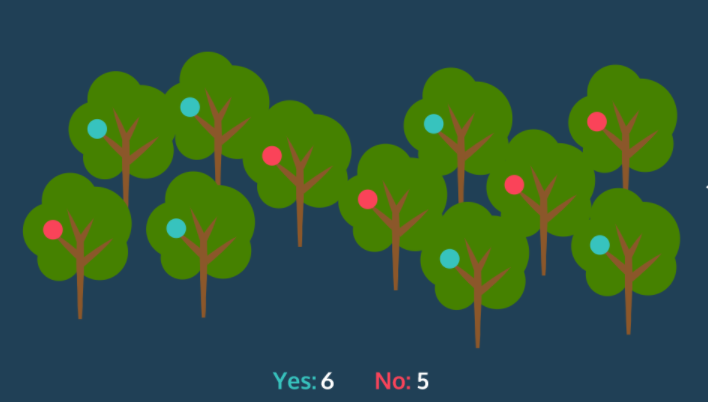

In [ ]:
## 랜덤 포레스트
# 머신러닝에서 자주 사용되는 알고리즘으로 "랜덤 포레스트(숲)"라는 것이 있다. (인기투표)
# 이는 학습 전용 데이터를 샘플링해서 여러 개의 의사결정 트리를 만들고, 
# # 만들어진 의사결정 트리를 기반으로 다수결로 결과를 결정하는 방법이다.
# 다수결로 결과를 유도하므로 높은 정밀도를 자랑한다. 
# 학습 데이터를 무작위로 샘플링해서 만들어진 다수의 ”의사결정 트리“라는 것은 트리 구조를 하고 있는 그래프인데 
# 예측과 분류를 수행하는 알고리즘 자체를 의사결정 트리라고 부르기도 한다.

import urllib.request as req
local= "mushroom.csv"   # 독이 있으면 ”p(poisonous)“, 식용이면 ”e(edible)“이다. 첫번째 열
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
req.urlretrieve(url, local)
print("ok")

In [ ]:
# 두 번째 열은 버섯의 머리모양이다.
# 네 번째 열은 버섯 머리 색이다. 
# 머신러닝을 할 때는 이를 숫자로 변환
# 각의 기호가 한 글자라는 것에 주목해서 각 기호를 문자 코드로 변환해서 활용하자.
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 데이터 읽어 들이기--- (※1)
mr = pd.read_csv("mushroom.csv", header=None)
# 데이터 내부의 기호를 숫자로 변환하기--- (※2)
label = []
data = []
attr_list = []
for row_index, row in mr.iterrows(): # dataframe에 있는 값을 한행씩 가져오기 위해 사용된 iterrows()함수 
    label.append(row.iloc[0]) # 첫번째 열값을 가져온다.  독의 유무
    row_data = [] 
    for v in row.iloc[1:]: 
        row_data.append(ord(v)) # 두번째 열 부터 문자에 해당하는 숫자로 변환하여 저장
    data.append(row_data)

# 학습 전용과 테스트 전용 데이터로 나누기 --- (※3)
data_train, data_test, label_train, label_test = train_test_split(data, label)
# 데이터 학습시키기 --- (※4)
clf = RandomForestClassifier() #  램덤 포레스트객체 생성
clf.fit(data_train, label_train)
# 데이터 예측하기 --- (※5)
predict = clf.predict(data_test)
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 데이터 읽어 들이기
mr = pd.read_csv("mushroom.csv", header=None)
# 데이터 내부의 분류 변수 전개하기
label = []
data = []
attr_list = []
#print(mr)
# print(mr.iloc[0])
# print(mr.iloc[0][0])
# print(mr.iloc[0][1:])
for row_index, row in mr.iterrows():
    label.append(row.iloc[0]) # 첫 번째 열에 있는 독이 있는 없는 지 
    exdata = [] 
    for col, v in enumerate(row.iloc[1:]):
        if row_index == 0:   
            attr = {"dic": {}, "cnt":0}
            attr_list.append(attr)
            #print(attr_list)
        else:
            attr = attr_list[col]
        
        
        # 버섯의 특징 기호를 배열로 나타내기
        d = [0,0,0,0,0,0,0,0,0,0,0,0]
        if v in attr["dic"]:
            idx = attr["dic"][v]
        else:
            idx = attr["cnt"]
            attr["dic"][v] = idx
            attr["cnt"] += 1
        d[idx] = 1
        exdata += d
    data.append(exdata)
#print(data[0:5])
# 학습 전용 데이터와 테스트 전용 데이터로 나누기
data_train, data_test, label_train, label_test = train_test_split(data, label)
# 데이터 학습시키기
clf = RandomForestClassifier()
clf.fit(data_train, label_train)
# 데이터 예측하기
predict = clf.predict(data_test)
# 결과 테스트하기
ac_score = metrics.accuracy_score(label_test, predict)
print("정답률 =", ac_score)

In [ ]:
# 데이터를 검증하는 방법
# 크로스 밸리데이션 (교차 검증)
# K분할 교차 검증(K-fold cross validation)
# ① 집합 x를 A,B,C로 분할한다. 
# ② A를 덱스트 전용 데이터, 나머지 B/C를 훈련 전용 데이터로 사용해 분류 정밀도 s1을 구한다.
# ③ B를 덱스트 전용 데이터, 나머지 A/C를 훈련 전용 데이터로 사용해 분류 정밀도 s2을 구한다.
# ④ C를 덱스트 전용 데이터, 나머지 A/B를 훈련 전용 데이터로 사용해 분류 정밀도 s3을 구한다.
# ⑤ 분류 정밀도 s1,s2,s3의 평균을 구해 최종적인 분류 정밀도를 구한다.

from sklearn import svm, metrics
import random, re
# 붓꽃의 CSV 파일 읽어 들이기 --- (※1)
lines = open('iris.csv', 'r', encoding='utf-8').read().split("\n")
f_tonum = lambda n : float(n) if re.match(r'^[0-9\.]+$', n) else n
f_cols  = lambda li: list(map(f_tonum,li.strip().split(',')))
csv = list(map(f_cols, lines))
#print(csv)
del csv[0] # 헤더 제거하기
random.shuffle(csv) # 데이터 섞기
# 데이터를 K개로 분할하기 --- (※2)
K = 5 
csvk = [ [] for i in range(K) ] # 다섯개의 리스트를 가진 리스트
for i in range(len(csv)):
    csvk[i % K].append(csv[i]) #  i를 k로 나눈 나머지 index에 csv[i]값을 저장
# print(csvk[0]);print(csvk[1]);print(csvk[2]);print(csvk[3]);print(csvk[4]);
# 리스트를 훈련 전용 데이터와 테스트 전용 데이터로 분할하는 함수
def split_data_label(rows):
    data = []; label = []
    for row in rows:
        data.append(row[0:4])
        label.append(row[4])
    return (data, label)
# 정답률 구하기 --- (※3)
def calc_score(test, train):
    print("실행")
    test_f, test_l = split_data_label(test)
    train_f, train_l = split_data_label(train)
    # 학습시키고 정답률 구하기
    clf = svm.SVC()
    clf.fit(train_f, train_l)
    pre = clf.predict(test_f)
    return metrics.accuracy_score(test_l, pre) 
# K개로 분할해서 정답률 구하기 --- (※4)
score_list = []

for testc in csvk:
    #print("A : ", testc)
    # testc 이외의 데이터를 훈련 전용 데이터로 사용하기 : csvk에서 처음 것만 test용 나머지는 훈련용으로 사용
    trainc = []
    for i in csvk:
        if i != testc: 
            #print("B :  ",i)
            trainc += i
    sc = calc_score(testc, trainc)
    score_list.append(sc) # 각 정답률을 리스트에 저장

print("각각의 정답률 =", score_list)
print("평균 정답률 =", sum(score_list) / len(score_list))

In [ ]:
import pandas as pd
from sklearn import svm, metrics, model_selection
import random, re
# 붓꽃의 CSV 데이터 읽어 들이기 --- (※1)
csv = pd.read_csv('iris.csv')
# 리스트를 훈련 전용 데이터와 테스트 전용 데이터로 분할하기 --- (※2)
data = csv[["SepalLength","SepalWidth","PetalLength","PetalWidth"]]
label = csv["Name"]
# 크로스 밸리데이션하기 --- (※3)
clf = svm.SVC()
scores = model_selection.cross_val_score(clf, data, label, cv=5)
print("각각의 정답률 =", scores)
print("평균 정답률 =", scores.mean())

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
x_train,x_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state = 0)

print("훈련 세트의 크기 : {} 테스트 세트의 크기 {}".format(x_train.shape[0],x_test.shape[0]))

best_score = 0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        svm = SVC(gamma = gamma,C = C)
        svm.fit(x_train,y_train)
        score = svm.score(x_test,y_test)

        if score > best_score:
            best_score = score
            best_parameters = {'C' : C,'gamma' : gamma}


print("최고 점수 {:.2f}".format(best_score))
print("최적 매개변수 : ",best_parameters)


In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 데이터를 로딩하고 학습데이타와 테스트 데이터 분리
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=121)
dtree = DecisionTreeClassifier()

### parameter 들을 dictionary 형태로 설정
parameters = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}


# param_grid의 하이퍼 파라미터들을 3개의 train, test set fold 로 나누어서 테스트 수행 설정.  
### refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.  
grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=3, refit=True)

# 붓꽃 Train 데이터로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
grid_dtree.fit(X_train, y_train)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_dtree.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

In [ ]:
# 그리드 서치
# 매개변수가 여러개를 지정할 수 있는데 적절하게 매개변수를 지정을 해야 정답률이 높아지게 된다.
# 어떤 매개변수가 적당한지 조사하는 방법을 '그리드 서치'라고 한다.
# 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법 
# 매개변수를 튜닝하여 일반화 성능을 개선해줌
import pandas as pd
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
# MNIST 학습 데이터 읽어 들이기 --- (※1)
train_csv = pd.read_csv("./mnist/train.csv")
test_csv  = pd.read_csv("./mnist/t10k.csv")
# 필요한 열 추출하기 --- (※2)
train_label = train_csv.iloc[:, 0]
train_data  = train_csv.iloc[:, 1:577]
test_label  = test_csv.iloc[:, 0]
test_data   = test_csv.iloc[:, 1:577]
print("학습 데이터의 수 =", len(train_label))
# 그리드 서치 매개변수 설정 --- (※3)
### parameter 들을 dictionary 형태로 설정

params = [
    {"C": [1,10,100,1000], "kernel":["linear"]},
    {"C": [1,10,100,1000], "kernel":["rbf"], "gamma":[0.001, 0.0001]}
]

# 그리드 서치 수행 --- (※4)
clf = GridSearchCV( svm.SVC(), params, n_jobs=-1 )
clf.fit(train_data, train_label)
print("학습기 =", clf.best_estimator_)
# 테스트 데이터 확인하기 --- (※5)
pre = clf.predict(test_data)
ac_score = metrics.accuracy_score(pre, test_label)
print("정답률 =",ac_score)